In [10]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras import backend as keras

from keras.preprocessing.image import ImageDataGenerator
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
def unet(pretrained_weights = None,input_size = (224,224,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
#     merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
    merge6 = concatenate([drop4,up6], axis=3)

    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
#     merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
    merge7 = concatenate([conv3,up7], axis=3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
#     merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
    merge8 = concatenate([conv2,up8], axis=3)

    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
#     merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
    merge9 = concatenate([conv1,up9], axis=3)

    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-5), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [3]:
model = unet()

/home/arl/.local/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [4]:
images = np.load("imgs.npy")
annos  = np.load("segs.npy")
ids    = np.load("ids.npy")

In [5]:
np.unique(annos)

array([0, 1], dtype=uint32)

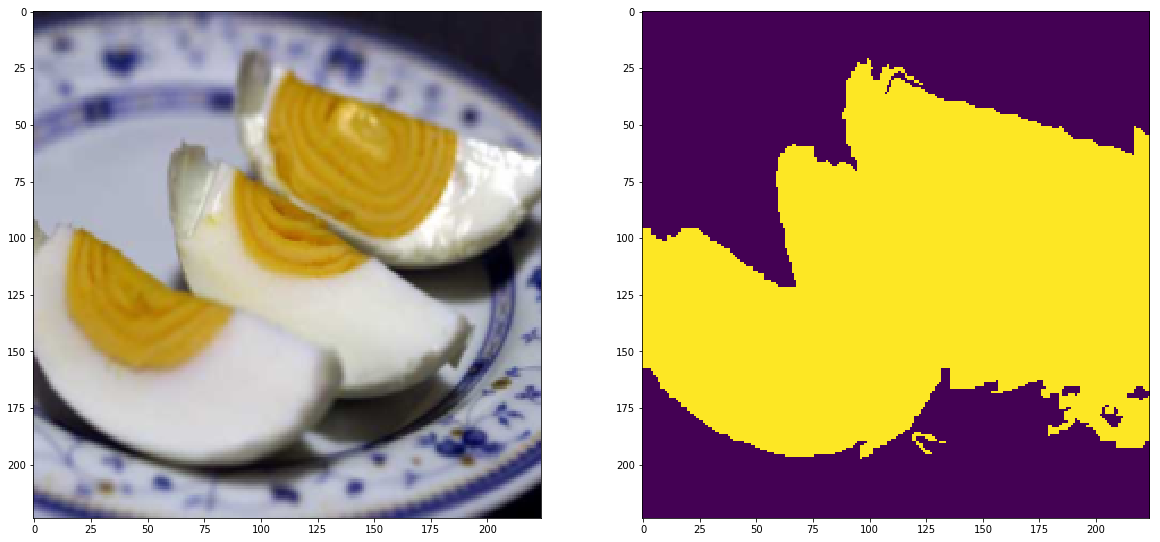

In [6]:
from random import randint
rand_id = randint(0,len(images))
sg = annos[rand_id][:,:,0]
im = images[rand_id]

plt.figure(figsize=(20,10))

plt.subplot(121)
plt.imshow(im)

plt.subplot(122)
plt.imshow(sg)


In [7]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(images, annos, test_size=0.33, random_state=42)

In [12]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0000001)

model_checkpoint = ModelCheckpoint('unet_malayfood.hdf5',
                                   monitor='val_loss',
                                   verbose=1, 
                                   save_best_only=True)

In [ ]:
History = model.fit(x_train, y_train,
          epochs=50,
          batch_size=32,
          validation_data=(x_test, y_test),
          shuffle = True,
          callbacks=[model_checkpoint, reduce_lr])

Train on 8324 samples, validate on 4100 samples
Epoch 1/50
6112/8324 [=====================>........] - ETA: 4:10 - loss: 0.6934 - acc: 0.6101

In [ ]:
r = randint(0, len(x_train))
w = model.predict(x_train[r:r+2])
plt.imshow(w[0,:,:,0]), r